<a href="https://colab.research.google.com/github/Lasulux/Midterm_Project/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preview code from:
https://www.kaggle.com/kmader/malaria-preview

Visualization code from:
https://github.com/maki-ai/SSD-Tensorflow/blob/pazmany_dl/notebooks/visualization.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import cv2
import random
import matplotlib.image as mpimg
import matplotlib.cm as mpcm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path
from skimage.io import imread
from skimage.color import label2rgb
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
malaria_dir = Path('../input/malaria/malaria/')

In [0]:
def plt_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!"""
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=5, color='white')
    plt.show()

In [0]:
def cat_to_num(category):
  categories = ['red blood cell','leukocyte','trophozoite','ring','schizont','gametocyte','difficult']
  num = categories.index(category)
  return num

In [31]:
train_df = pd.read_json('/content/drive/My Drive/malaria-bounding-boxes/malaria/malaria/training.json')
train_df['path'] = train_df['image'].map(lambda x:  x['pathname'][1:])
print(train_df.shape[0], 'images')
print(train_df.shape[0], 'images')
train_df.sample(5)

1208 images
1208 images


,image,objects,path
469,{'checksum': 'f71ba3da25b4e69c79cdb18ebcb291a3...,"[{'bounding_box': {'minimum': {'r': 758, 'c': ...",images/a1669b59-fe09-4fe6-ba9f-06bec6725502.png
271,{'checksum': 'a17902f432221520af78b6d3aa9970bd...,"[{'bounding_box': {'minimum': {'r': 1005, 'c':...",images/70a95e58-ba60-4c1f-adcd-49c198dc2ba0.png
969,{'checksum': 'ca4c50abc1276160e38bafac28f37bbf...,"[{'bounding_box': {'minimum': {'r': 172, 'c': ...",images/6afd8203-d61a-4e9b-a4cf-dcb53a16b57c.png
726,{'checksum': 'e3657caef61d675b127971811e23f301...,"[{'bounding_box': {'minimum': {'r': 466, 'c': ...",images/63055d1b-5221-4c80-8b39-37ac069a1b5c.png
432,{'checksum': 'ea48a88b3725a036c2ab1e53dfb458bc...,"[{'bounding_box': {'minimum': {'r': 1008, 'c':...",images/a0785022-e82b-4878-b9d4-19cb7b75213f.png


1200


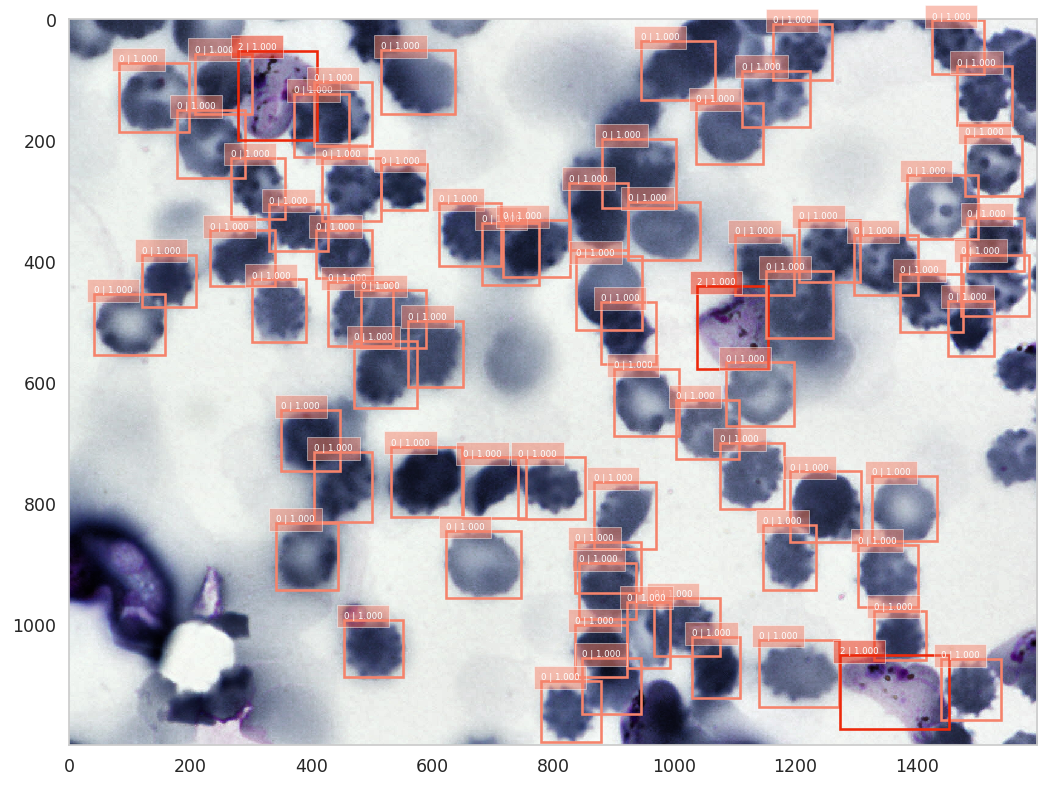

In [87]:
test_row = train_df.iloc[0]
def show_image_boxes(in_row, ax=None):
    #fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    c_img = imread('drive/My Drive/malaria-bounding-boxes/malaria/malaria/' + in_row['path'])
    lab_img = np.zeros((c_img.shape[0], c_img.shape[1]), dtype='int')
    classes=[]
    scores=[]
    bboxes=[]
    for c_obj in in_row['objects']:
        #print('found obj')
        bbx1 = c_obj['bounding_box']['minimum']['r']/lab_img.shape[0]
        bby1 = c_obj['bounding_box']['minimum']['c']/lab_img.shape[1]
        bbx2 = c_obj['bounding_box']['maximum']['r']/lab_img.shape[0]
        bby2 = c_obj['bounding_box']['maximum']['c']/lab_img.shape[1]
        classes.append(cat_to_num(c_obj['category']))
        scores.append(1.00)
        bboxes.append([bbx1,bby1,bbx2,bby2])
    bboxes=np.array(bboxes)
    classes=np.array(classes)
    scores=np.array(scores)
    bboxes=np.reshape(bboxes,(-1,4))
    plt_bboxes(c_img, classes, scores, bboxes)
show_image_boxes(test_row)